### Match report for Fleetwood vs Wycombe, English League One (11/02/2020)
___

#### Notebook summary

This notebook demonstrates how to plot a variety of useful metrics that are commonly used in the football analytics community to analyse matches. The underlying data is spatio-temporal event data from the provider Statsbomb. Specifically the notebook demonstrates different plots that represent different technical and tactical aspects of the football (and can be useful for coaches and analysts when gaining insight from matches).

#### Index

1. [Imports](#Imports)
2. [Off the ball](#Off-the-ball) <br>
    a. [Pressure 2d histogram](#Pressure-2d-histogram) <br>
    b. [Cumulative pressure line](#Cumulative-pressure-line) <br>
    c. [Individual player pressure scatter](#Individual-player-pressure-scatter) <br>
3. [On the ball](#On-the-ball)
4. [Technical performance](#Technical-performance) <br>
    a. [Individual](#Individual) <br>
    b. [Team](#Team)
___

#### Imports

In [1]:
# standard libraries
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import importlib

# modules
from match_report import utils
from match_report import data_loader
from match_report import kpis
from match_report import pass_net

In [2]:
# provide path to data location
raw_csv = pd.read_csv('./match_report/data/FTFC_Data_Scientist_Test_Data.csv')

### Off the ball
___

Tactical analyses of match events looking at both on the ball (passing) and off the ball (pressing)

#### Pressure 2d histogram

2d histograms overlayed on a pitch plot highlight the frequency of pressure events in different areas of the pitch. The darker the colour, the more frequent the pressing events. This is very useful to determine which areas of the pitch a team is subjecting most pressure.

In [3]:
pressure_events = data_loader.event_selector(raw_csv,'Pressure')

In [8]:
# pressure events for selected team and half
team_pressure = (pressure_events[(pressure_events['team_name']=='Fleetwood Town')])

Fleetwoods pressing activity is concentrated down their right side. There is very little pressing in the centre of the park, they are letting Wycombe have control of the ball in these areas but as soon as the ball goes to the flanks, the press is applied to prevent crosses coming in. This is a sensible tactical approach given that Wycombes main threat is from Akinfenwa who predominantly scores with his head.

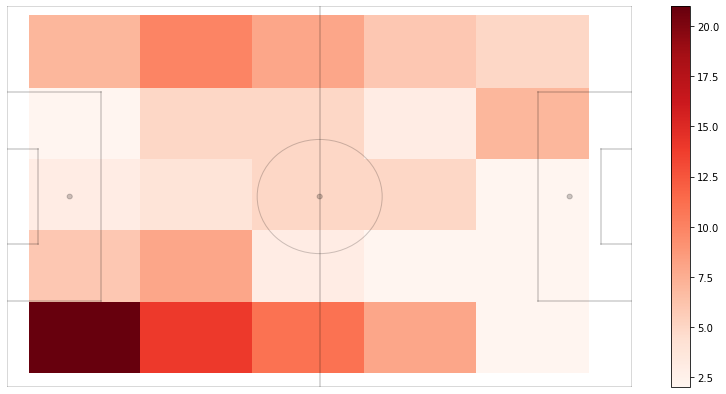

In [25]:
fig,ax = utils.statsbomb_pitch_plot(14,7,opacity=0.2)
utils.event_2dhist(events = team_pressure,
           hist_bins = (5,5),
           colour = 'Reds')

#### Cumulative pressure line

Representing the 2d histogram as a line plot also helps to see the spatial distribution in one dimension. Rather than seeing the location of pressing events in a particular X,Y region of the pitch, the cumulative number of pressing events across each band of the pitch can be seen. This can be used to look at the level of pressing by a team as an entire unit (in each pitch band). The halfway line is clearly marked. 

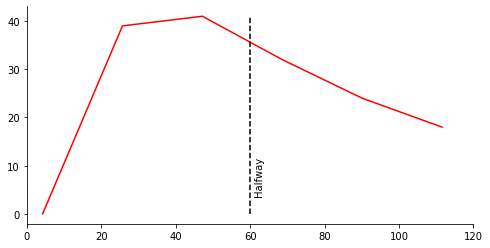

In [10]:
utils.cumulative_event_line(events = team_pressure,
                      hist_bins = (5,5),
                      figsize = (8,4),
                      colour = 'r')

#### Individual player pressure scatter

Individual player pressing maps can be plotted to highlight which players were pressing most (and where the most pressure was applied). The size of the dots represent the duration of the pressing event (larger circle means longer press).

In [11]:
press_players =(
    team_pressure.groupby(['player_name'])
                   ['player_name']
                   .count()
                   .sort_values(ascending=False)
)

In [12]:
# take the top 3
top_press_players = press_players[:3]

In [13]:
player_press_events = []
for i in top_press_players.index:
    player_press_events.append(team_pressure[team_pressure['player_name']==i])

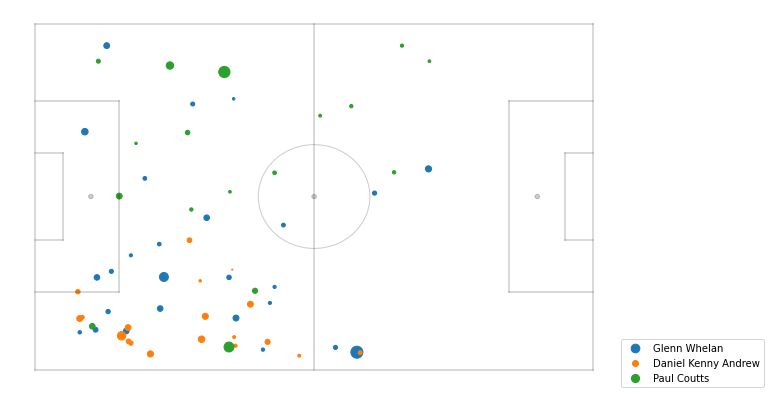

In [44]:
fig,ax = utils.statsbomb_pitch_plot(11,7,opacity=0.2)

gen_exp = (x for x in player_press_events)
for i in gen_exp:
    _=ax.scatter(i['location_x'],
                 i['location_y'],
                 s=i['duration']*25,
                 zorder=1,
                label=i['player_name'].values[0]
                )
    _=ax.legend(loc=(1,0))

### On the ball
___

#### Passing network

Now to on the ball events. Passing networks are great to understand the key links between players.

In [26]:
# first half
events = raw_csv.drop_duplicates('timestamp')

In [27]:
# get the starting line up (name and position)
ftfc_start = raw_csv[['formation_player_name','formation_position_name']].dropna()[:22].reset_index(drop=True)[11:]
wwfc_start = raw_csv[['formation_player_name','formation_position_name']].dropna()[:22].reset_index(drop=True)[:11]

In [28]:
# ftfc events
ftfc_events = events[(events['possession_team_name']=='Fleetwood Town')&
                    (events['player_name'].isin(ftfc_start['formation_player_name']))].drop_duplicates('timestamp')

In [29]:
# ftfc passes
passes = ftfc_events[(ftfc_events['event_type_name']=='Pass')&
                   (ftfc_events['outcome_name'].isnull())]

The network contains a lot of information. The location of the circles represents the average touch location of the Fleetwood players during the game. The size of the circles linearly scales the number of touches that the player had (so Souttar had very few touches compared to Coutts). There is also the potential to linearly scale the colour of the nodes to represent xG, but I feel that this clutters the image a bit.

The lines between the players indicate pass combinations. The thicker the line the more completed passes between the players involved. The colours of the line are linearly scaled to reflect xG contributions for each pass combination, going from light blue at the low end of the scale through to purple at the high end. Therefore, it can easily be seen that the key pass combinations (ones that contribute most to xG) are the ones between Coutts and Whelan, McKay and Andrew, and Coutts and Evans. What to take from this if you're the opposition? Break these links and you'll disrupt Fleetwoods chance creation network. 

/Users/fraewi/Documents/Projects/my_stuff/match_report/match_report/pass_net.py:95: RuntimeWarning: divide by zero encountered in double_scalars
  xgc.append((xg/passes.sum())*passes)


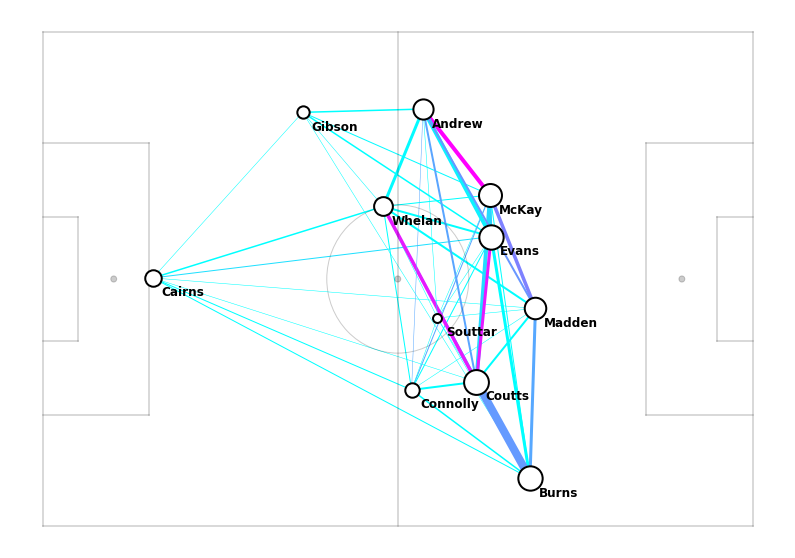

In [30]:
fig,ax = utils.statsbomb_pitch_plot(14,10,opacity=0.2)

# nodes (total touches is size of node, location is ave touch loc)
plyr_locs = pass_net.player_ave_locations(ftfc_events,cm.Wistia)
for i in plyr_locs.index:
    _=ax.scatter(plyr_locs.loc[i,'location_x'],
                 plyr_locs.loc[i,'location_y'],
                s=plyr_locs.loc[i,'touch_count']*8,
                 label=i,
                edgecolors='k',#plyr_locs['xg_colors'],
                 facecolors='white',
                 linewidth=2,
                 zorder=10)
    _=ax.annotate(i.split()[-1],(plyr_locs.loc[i,'location_x']+1.5,
                                 plyr_locs.loc[i,'location_y']+3),weight='bold',fontsize=12)

# links between players (width is number of passes)
pn = pass_net.pass_network_combinations_df(passes,ftfc_events,ftfc_start,cm.cool)

for i in pn.index:
    ax.plot([pn.loc[i,'loc_x1'],pn.loc[i,'loc_x2']],
         [pn.loc[i,'loc_y1'],pn.loc[i,'loc_y2']],
         lw = pn.loc[i,'pass_count']/2,
            color=pn.loc[i,'xgc_colors'],# line width
         zorder=-1)
    
_=ax.invert_yaxis()

#### Passing kernel density

Kernel density estimation fits a multinomial probability distribution to the data. They are similar to histograms except are continuous rather than discreet. Therefore the gradients of passing activity can be easily seen. Using the pass events variable created earlier, we can see KDEs for either team and for any match period.

For Fleetwood here, it is evident where the regions of passing density occur. The left and right wings feature prominently (reflecting what we have seen in the passing network previously).

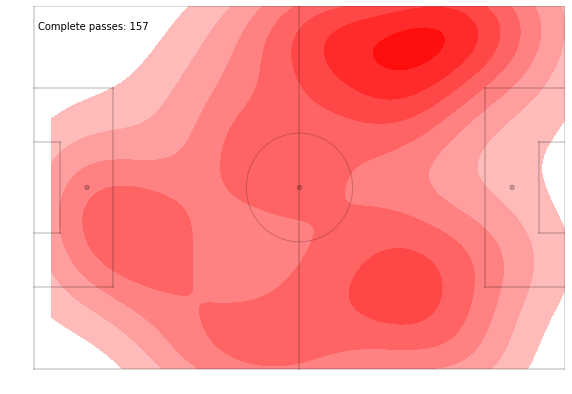

In [53]:
_=utils.statsbomb_pitch_plot(10,7,opacity=0.2)
ax = sns.kdeplot(passes['location_x'],passes['location_y'],
                 shade=True,
                 n_levels=8,
                 color='r',
                 cut=0)
_=ax.collections[0].set_alpha(0)
_=plt.annotate('Complete passes: %d' %len(passes),(1,75))

#### Deep progressions

Deep progressions are defined as passes, carries and dribbles into the opposition final third. They enable an understanding of a teams attacking intent. Here the focus is on passes but the code can easily be extended to include carries and dribbles as well.

In [31]:
# load all events (pass events are only successful passes)
all_events = data_loader.event_selector(raw_csv)

In [32]:
# into the final third is x>=80
deep_pass = (all_events[(all_events['event_type_name']=='Pass')
                   &(all_events['end_location_x']>=80)])

In [33]:
# successful fleetwood deep passes in 2nd half
ftfc_sdp = deep_pass[(deep_pass['possession_team_name']=='Fleetwood Town')
              &(deep_pass['outcome_name'].isnull())
              &(deep_pass['period']==2)].reset_index()
# unsuccessful fleetwood deep passes in 2nd half
ftfc_usdp = deep_pass[(deep_pass['possession_team_name']=='Fleetwood Town')
              &(deep_pass['outcome_name']=='Incomplete')
              &(deep_pass['period']==2)].reset_index()

Red are the successful deep progressions and blue unsuccessful. Many of the deep progressions through the centre of the park are unsuccessful, suggesting that Wycombe are very compact in the central areas of the pitch, making progression here difficult.

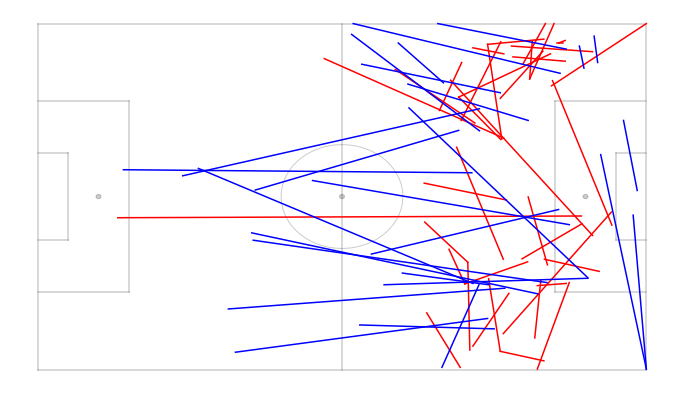

In [56]:
fig,ax=utils.statsbomb_pitch_plot(12,7,opacity=0.2)

for i in range(len(ftfc_sdp)):
    ax.plot([ftfc_sdp['location_x'][i],ftfc_sdp['end_location_x'][i]],
           [ftfc_sdp['location_y'][i],ftfc_sdp['end_location_y'][i]],
           c='r',
           label='Successful')

for i in range(len(ftfc_usdp)):
    ax.plot([ftfc_usdp['location_x'][i],ftfc_usdp['end_location_x'][i]],
           [ftfc_usdp['location_y'][i],ftfc_usdp['end_location_y'][i]],
           c='b',
           label='Failed')
    

### Technical performance
___

Previously the focus has been on the tactical performance of the team. Now we can look at technical performance of individual players and the team as a whole. Technical performance is concerned with those aspects of football that are related to technique e.g. shooting, tackling, individual pass accuracy etc. Key Performance Indicators (KPIs) for each position on the field have been determined based on commonly used metrics in the analytics community (including what Statsbomb deem important). These can be found in the kpis.py module.

#### Individual

In [38]:
# isolate all the events from the all events variable for each position

# forwards
cfs = all_events[((all_events['team_name']=='Fleetwood Town')
                 |(all_events['team_name']=='Wycombe Wanderers'))
       &((all_events['player_position_name']=='Left Center Forward')
            |(all_events['player_position_name']=='Right Center Forward'))]

# wing backs
wbs = all_events[((all_events['team_name']=='Fleetwood Town')
                 |(all_events['team_name']=='Wycombe Wanderers'))
       &((all_events['player_position_name']=='Left Back')
            |(all_events['player_position_name']=='Right Back')
        |(all_events['player_position_name']=='Right Wing Back')
        |(all_events['player_position_name']=='Left Wing Back'))]

# centre midfielders
cms = all_events[((all_events['team_name']=='Fleetwood Town')
                 |(all_events['team_name']=='Wycombe Wanderers'))
       &((all_events['player_position_name']=='Center Defensive Midfield')
            |(all_events['player_position_name']=='Left Center Midfield')
        |(all_events['player_position_name']=='Right Center Midfield'))]

# centre backs
cbs = all_events[((all_events['team_name']=='Fleetwood Town')
                 |(all_events['team_name']=='Wycombe Wanderers'))
       &((all_events['player_position_name']=='Center Back')
            |(all_events['player_position_name']=='Left Center Back')
        |(all_events['player_position_name']=='Right Center Back'))]

In [39]:
# use the kpi module functions to display a table of stats for different positions
kpis.cm_kpis(cms)

,pass_%,deep prog.,succ. dribbles,fouls_won,pressures,tack
Alexander Pattison,55.00,25,1.0,1.0,12,1.0
Barry McKay,81.48,50,4.0,2.0,15,1.0
Dominic Gape,69.44,55,0.0,0.0,12,1.0
Fred Onyedinma,83.33,9,0.0,0.0,3,0.0
Glenn Whelan,72.50,45,0.0,0.0,26,3.0
Nicholas Freeman,61.76,50,0.0,1.0,11,1.0
Paul Coutts,69.81,67,1.0,1.0,17,0.0
Harvey Saunders,0.00,1,0.0,1.0,16,0.0


#### Team

We can look at technical KPIs across the team as a whole by using the team function in the kpi module.

In [40]:
kpis.team_kpi(all_events)

team_name,Fleetwood Town,Wycombe Wanderers
xg,2.14,0.53
shots,18.00,11.00
xg/shot,0.12,0.05
box_touches,79.00,72.00
shot_touch%,22.78,15.28
deep prog,455.00,449.00
crosses,9.00,17.00
pressures,154.00,115.00
pass%,62.80,61.25
